# Zero-Shot Classification using CLAP Models

Embeddings used in these experiments are extracted in the extract_embeddings.ipynb notebook. Each experiment is executed on MSCLAP and LAION CLAP.

Experiments:
1. k-fold evaluation. Accuracy and average precision is reported. The results for each fold are averaged over 1k calculations. The experiment is repeated with and without overlapping samples between folds, comprising 200 and 17 folds respectively. 
2. Consolidate classes.

In [73]:
from msclap import CLAP
import laion_clap
import json
import pandas as pd
from dataset import DatasetUCS
import torch
import matplotlib.pyplot as plt
import configs.graphics_settings as graphics_settings
import random
import IPython.display as ipd
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, average_precision_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay
import os
import numpy as np
from tqdm import tqdm
from utils.experiment_logger import ExperimentLogger
from utils.set_torch_device import set_torch_device
from utils.seed_everything import seed_everything

In [72]:
# Load Testing Set
with open ('configs/zero-shot.json', 'r') as f:
    settings = json.load (f)

# Load USC Classes
with open ('data/ucs_official/ucs_classes.json', 'r') as f:
    ucs_classes = json.load (f)

device, _ = set_torch_device()

In [69]:
# Load models
msclap_model = CLAP(version = '2023', use_cuda=True) # version can be 2022 or 2023
laion_clap_model = laion_clap.CLAP_Module(enable_fusion=False)
laion_clap_model.load_ckpt()

Load our best checkpoint in the paper.
The checkpoint is already downloaded
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm2.we

In [61]:
def k_fold_zs_evaluation(true, pred):
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred, average='macro')
    recall = recall_score(true, pred, average='macro')
    f1 = f1_score(true, pred, average='macro')
    average_precision = average_precision_score(np.array(true).reshape(-1, 1), np.array(pred).reshape(-1, 1))
    
    return accuracy, precision, recall, f1, average_precision

def k_fold_zs_predict(audio_embeddings:torch.Tensor, ground_truth_path:str, text_encoding_func, similarity_func, max_samples:int=None):
    """
    This function evaluates pytorch audio embeddings on zero-shot classification.

    Args:
    - audio_embeddings: extracted pytorch embeddings, shape (batch_size, n_classes, latent_dim). Indeces must correspond to the ground truth csv.
    - ground_truth_path: path to directory containing csv files, one for each fold
    - text_encoding_func: the function to use to extract text embeddings
    - similarity_func: function to be used to compute similarity. Must take two sets of embeddings as input.
    - k_folds: must be equal or less than the number of folds
    - max_samples: slices the audio embeddings and ground truth csvs. Used for sanity checks.
    """
    from tqdm import tqdm

    fold_csv_list = [file for file in os.listdir(ground_truth_path)]

    total_acc = 0
    total_ap = 0
    pred = []
    true = []
    for (true_fold, pred_fold) in tqdm(zip(fold_csv_list, audio_embeddings), total=len(fold_csv_list)):
        # Load fold from csv, used to compare class 
        df = pd.read_csv(ground_truth_path + true_fold)
        dataset = DatasetUCS(df, settings, device='cpu', return_type='path')
        label_embeddings = text_encoding_func(dataset.get_unique_classes().tolist())

        for i in tqdm(range(len(dataset)), leave=False):
            _, _, class_name = dataset[i] # gold label
            
            current_emb = pred_fold[i].cpu()
            similarities = similarity_func(current_emb, torch.Tensor(label_embeddings))
            similarities = similarities.detach()
            probs = torch.softmax(similarities.unsqueeze(0), dim=1).detach().flatten() * 100
            idx = torch.argmax(probs)
            pred.append(idx.item())
            true.append(ucs_classes['class_to_int'][class_name])
            #indeces = torch.topk(probs, k=3).indices
            
    return true, pred

def load_embeddings_from_disk(dir_path:str):
    """
    Loads a list of torch embeddings and concatenates them along the first dimension. Output shape: (n_embeddings, (x.shape))

    Args:
    - dir_path: path to a directory containing pytorch embeddings. These embeddings must be of the same shape.
    """
    audio_embeddings = None
    for file in os.listdir(dir_path):
        if (audio_embeddings != None):
            audio_embeddings = torch.cat((audio_embeddings, torch.load(dir_path + file).unsqueeze(0)), dim=0)
        else:
            audio_embeddings = torch.load(dir_path + file).unsqueeze(0)

    return audio_embeddings

In [6]:
k_fold_200_audio_embeddings_laion = load_embeddings_from_disk(settings["k_fold_200-laion_audio_embeddings"])
k_fold_200_audio_embeddings_msclap = load_embeddings_from_disk(settings["k_fold_200-msclap_audio_embeddings"])
k_fold_17_audio_embeddings_laion = load_embeddings_from_disk(settings["k_fold_17-laion_audio_embeddings"]) 
k_fold_17_audio_embeddings_msclap = load_embeddings_from_disk(settings["k_fold_17-msclap_audio_embeddings"])

## MS CLAP
This section evaluates MSCLAP on Soundly-80k through the following metrics: Precision, Recall, Mean Average Precision

Predicted Class (Best Prediction): fireworks
Predicted Classes (Best Match To Worst): fireworks, explosions, archived
True Class: fireworks


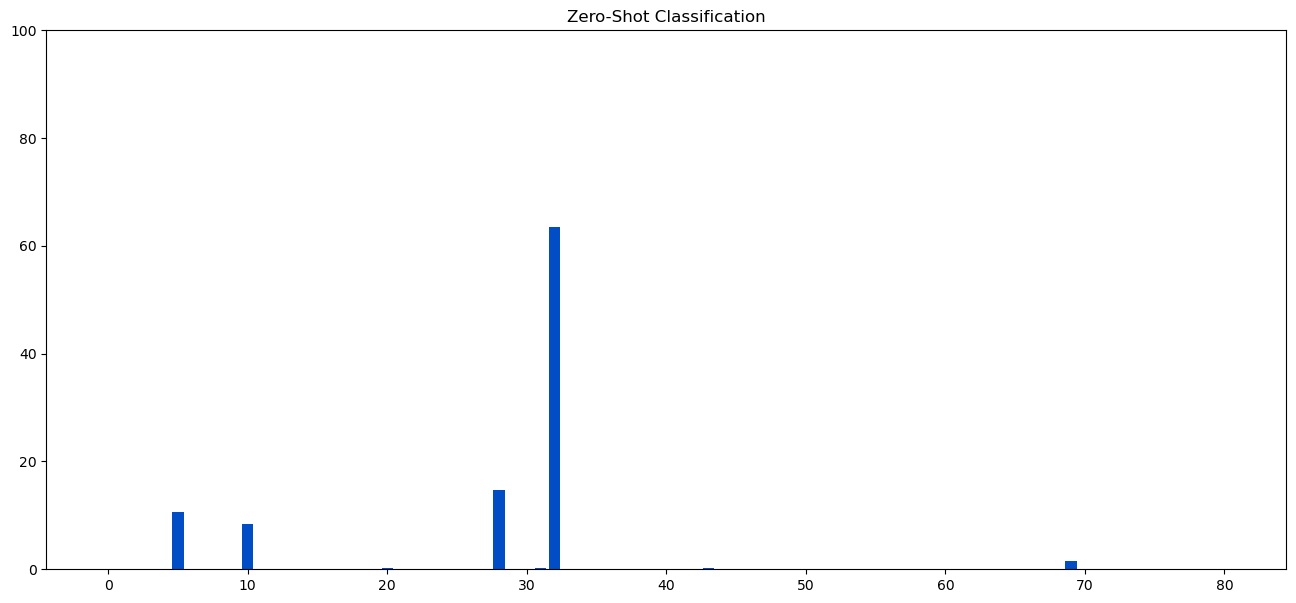

In [104]:
# This block outlines the process we go through for evaluation.

k_fold_embeddings = k_fold_17_audio_embeddings_msclap
# Sample randomly from the dataset.
fold_idx = random.randint(0, k_fold_embeddings.size()[0]-1)
sample_idx = random.randint(0, k_fold_embeddings.size()[1]-1)

df = pd.read_csv(settings["k_fold_200-ground_truth"] + f"zs_fold_{fold_idx+1}.csv")
dataset = DatasetUCS(df, settings, device='cpu', return_type='path')
path, label, class_name = dataset[sample_idx]
# Extract
#dataset_audio_embeddings = torch.load(settings['dataset_drive'] + settings['msclap_emb_path'])
label_embeddings = msclap_model.get_text_embeddings(dataset.get_unique_classes())
audio_embeddings = k_fold_embeddings[fold_idx][sample_idx].to(device)
similarities = msclap_model.compute_similarity(audio_embeddings, label_embeddings)
#similarities = torch.cosine_similarity(audio_embeddings, label_embeddings)
similarities = similarities.detach()

# Logits -> Probabilities, report prediction and ground truth.
probs = torch.softmax(similarities.view(-1, 1), dim=0).detach().flatten() * 100
idx = torch.argmax(probs).cpu()
probs = probs.cpu()
print(f"Predicted Class (Best Prediction): {dataset.get_unique_classes()[idx]}")
indeces = torch.topk(probs, k=3).indices
print(f"Predicted Classes (Best Match To Worst): {dataset.get_unique_classes()[indeces[0]]}, {dataset.get_unique_classes()[indeces[1]]}, {dataset.get_unique_classes()[indeces[2]]}")
print(f"True Class: {class_name}")

# Plot probabilities
fig = plt.figure(2, figsize=(16, 7))
ax = fig.subplots(1)
ax.set_title("Zero-Shot Classification")
ax.set_ylim(0, 100)
ax.bar(range(len(probs)), height=probs, color=graphics_settings.primary_color)

ipd.Audio(path)

# K-Fold Zero Shot Classification



In [66]:
experiment_logger = ExperimentLogger("logs/", "k-fold_17-zero_shot")

k-fold_17-zero_shot


In [67]:
msclap_k_fold_17_gold_labels, msclap_k_fold_17_pred_labels = k_fold_zs_predict(k_fold_17_audio_embeddings_msclap, settings['k_fold_17-ground_truth'], msclap_model.get_text_embeddings, msclap_model.compute_similarity)
msclap_k_fold_17_accuracy, msclap_k_fold_17_precision, msclap_k_fold_17_recall, msclap_k_fold_17_f1, msclap_k_fold_17_ap = k_fold_zs_evaluation(msclap_k_fold_17_gold_labels, msclap_k_fold_17_pred_labels)

print(f"MSCLAP Accuracy Score: {msclap_k_fold_17_accuracy}")
print(f"MSCLAP Average Precision Score: {msclap_k_fold_17_ap}")
print(f"MSCLAP Precision Score: {msclap_k_fold_17_precision}")
print(f"MSCLAP Recall Score: {msclap_k_fold_17_recall}")
print(f"MSCLAP F1 Score: {msclap_k_fold_17_f1}")

laion_k_fold_17_gold_labels, laion_k_fold_17_pred_labels = k_fold_zs_predict(k_fold_17_audio_embeddings_laion, settings['k_fold_17-ground_truth'], laion_clap_model.get_text_embedding, torch.cosine_similarity)
laion_k_fold_17_accuracy, laion_k_fold_17_precision, laion_k_fold_17_recall, laion_k_fold_17_f1, laion_k_fold_17_ap = k_fold_zs_evaluation(laion_k_fold_17_gold_labels, laion_k_fold_17_pred_labels)

print(f"LAION Accuracy Score: {laion_k_fold_17_accuracy}")
print(f"LAION Average Precision Score: {laion_k_fold_17_ap}")
print(f"LAION Precision Score: {laion_k_fold_17_precision}")
print(f"LAION Recall Score: {laion_k_fold_17_recall}")
print(f"LAION F1 Score: {laion_k_fold_17_f1}")

experiment_logger.experiment_name = "k_fold_17-zero_shot"
results = {
    "msclap" : {
        "accuracy" : msclap_k_fold_17_accuracy,
        "average_precision" : msclap_k_fold_17_ap,
        "recall" : msclap_k_fold_17_recall,
        "precision" : msclap_k_fold_17_precision,
        "f1" : msclap_k_fold_17_f1
    },
    "laion" : {
        "accuracy" : laion_k_fold_17_accuracy,
        "average_precision" : laion_k_fold_17_ap,
        "recall" : laion_k_fold_17_recall,
        "precision" : laion_k_fold_17_precision,
        "f1" : laion_k_fold_17_f1
    }
}

experiment_logger.log_results(results)
experiment_logger.save_log()

100%|██████████| 17/17 [01:22<00:00,  4.88s/it]


MSCLAP Accuracy Score: 0.15177923021060277
MSCLAP Average Precision Score: 0.012177299627363396
MSCLAP Precision Score: 0.15164784842540607
MSCLAP Recall Score: 0.14992826398852221
MSCLAP F1 Score: 0.1284044500167286


100%|██████████| 17/17 [00:04<00:00,  3.64it/s]

LAION Accuracy Score: 0.1009440813362382
LAION Average Precision Score: 0.011166272334842872
LAION Precision Score: 0.11083372255124158
LAION Recall Score: 0.09971305595408894
LAION F1 Score: 0.0908112719617227


In [68]:
msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels = k_fold_zs_predict(k_fold_200_audio_embeddings_msclap, settings['k_fold_200-ground_truth'], msclap_model.get_text_embeddings, msclap_model.compute_similarity)
msclap_k_fold_200_accuracy, msclap_k_fold_200_precision, msclap_k_fold_200_recall, msclap_k_fold_200_f1, msclap_k_fold_200_ap = k_fold_zs_evaluation(msclap_k_fold_200_gold_labels, msclap_k_fold_200_pred_labels)

print(f"MSCLAP Accuracy Score: {msclap_k_fold_200_accuracy}")
print(f"MSCLAP Average Precision Score: {msclap_k_fold_200_ap}")
print(f"MSCLAP Precision Score: {msclap_k_fold_200_precision}")
print(f"MSCLAP Recall Score: {msclap_k_fold_200_recall}")
print(f"MSCLAP F1 Score: {msclap_k_fold_200_f1}")

laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels = k_fold_zs_predict(k_fold_200_audio_embeddings_laion, settings['k_fold_200-ground_truth'], laion_clap_model.get_text_embedding, torch.cosine_similarity)
laion_k_fold_200_accuracy, laion_k_fold_200_precision, laion_k_fold_200_recall, laion_k_fold_200_f1, laion_k_fold_200_ap = k_fold_zs_evaluation(laion_k_fold_200_gold_labels, laion_k_fold_200_pred_labels)

print(f"LAION Accuracy Score: {laion_k_fold_200_accuracy}")
print(f"LAION Average Precision Score: {laion_k_fold_200_ap}")
print(f"LAION Precision Score: {laion_k_fold_200_precision}")
print(f"LAION Recall Score: {laion_k_fold_200_recall}")
print(f"LAION F1 Score: {laion_k_fold_200_f1}")

experiment_logger.experiment_name = "k_fold_200-zero_shot-1"
results = {
    "msclap" : {
        "accuracy" : msclap_k_fold_200_accuracy,
        "average_precision" : msclap_k_fold_200_ap,
        "recall" : msclap_k_fold_200_recall,
        "precision" : msclap_k_fold_200_precision,
        "f1" : msclap_k_fold_200_f1
    },
    "laion" : {
        "accuracy" : laion_k_fold_200_accuracy,
        "average_precision" : laion_k_fold_200_ap,
        "recall" : laion_k_fold_200_recall,
        "precision" : laion_k_fold_200_precision,
        "f1" : laion_k_fold_200_f1
    }
}

experiment_logger.log_results(results)
experiment_logger.save_log()

100%|██████████| 200/200 [16:25<00:00,  4.93s/it]


MSCLAP Accuracy Score: 0.18469135802469136
MSCLAP Average Precision Score: 0.014966500837750224
MSCLAP Precision Score: 0.16735470189997015
MSCLAP Recall Score: 0.18243902439024393
MSCLAP F1 Score: 0.15082580381422153


100%|██████████| 200/200 [00:54<00:00,  3.67it/s]

LAION Accuracy Score: 0.17462962962962963
LAION Average Precision Score: 0.012225793013152412
LAION Precision Score: 0.12245947328814835
LAION Recall Score: 0.17462962962962963
LAION F1 Score: 0.13815064705220062


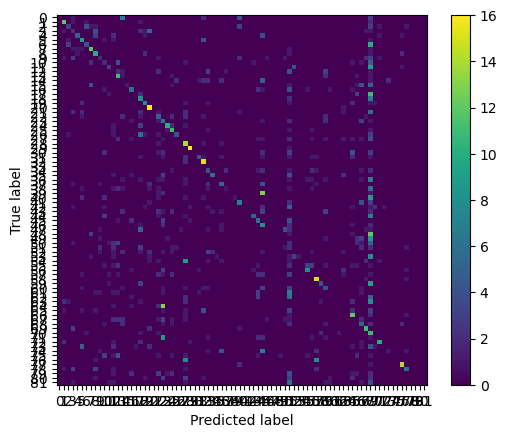

In [60]:
cmp = ConfusionMatrixDisplay.from_predictions(msclap_k_fold_17_gold_labels, msclap_k_fold_17_pred_labels, include_values=False)
fig, ax = plt.subplots(figsize=(28,28))
ax.set_title("Confusion Matrix (K-Fold 17) MSCLAP",fontsize=35, pad=20)
ax.set_xlabel("Predicted Label", fontsize=30)
ax.set_ylabel("True Label",fontsize=30)
cmp.plot(ax=ax)
plt.savefig("kfold17_msclap.png", dpi=300, bbox_inches='tight', transparent=False)

In [193]:
ucs_classes['int_to_class']["69"]

'trains'

In [112]:
mean_acc, mean_ap, pred, true = k_fold_zs_evaluation(k_fold_200_audio_embeddings_msclap, settings['k_fold_200-ground_truth'], msclap_model.get_text_embeddings, msclap_model.compute_similarity)

print(f"Accuracy Score: {mean_acc}")
print(f"Average Precision Score: {mean_ap}")

100%|██████████| 200/200 [14:11<00:00,  4.26s/it]

Accuracy Score: 0.7103513770180447
Average Precision Score: 0.07717890083229098
